## Табличное Q-обучение


Одним из наиболее популярных алгоритм обучения на основе временных различий является Q-обучение.

<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/678cb558a9d59c33ef4810c9618baf34a9577686">


<!-- Раскроем скобки:
$$Q(s,a)\leftarrow (1 - \alpha) \times Q(s,a)+\alpha \times \big (r(s)+\gamma\max_{a'}Q(a',s')\big ).$$ -->

Для обучения будем использовать среду Taxi-v3. Подробнее про данное окружение можно посмотреть в документации: https://gymnasium.farama.org/environments/toy_text/taxi/.

In [1]:
try:
    import google.colab
    COLAB = True
except ModuleNotFoundError:
    COLAB = False
    pass

if COLAB:
    !pip -q install "gymnasium[classic-control, atari, accept-rom-license]"
    !pip -q install piglet
    !pip -q install imageio_ffmpeg
    !pip -q install moviepy==1.0.3

In [2]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

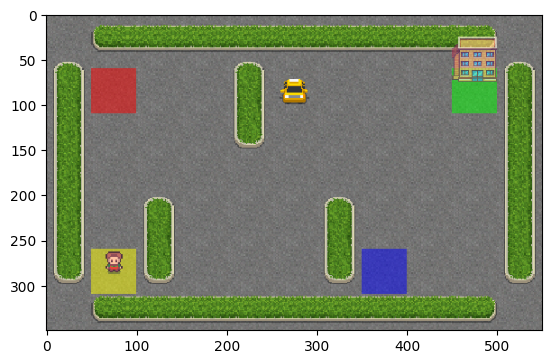

In [3]:
env = gym.make("Taxi-v3", render_mode='rgb_array')
env.reset()
plt.imshow(env.render())

In [4]:
def show_progress(rewards_batch, log):
    """Функция отображения прогресса обучения."""
    mean_reward = np.mean(rewards_batch)
    log.append(mean_reward)

    clear_output(True)
    plt.figure(figsize=[8, 4])
    plt.subplot(1, 2, 1)
    plt.plot(log, label='Mean rewards')
    plt.legend(loc=4)
    plt.show()

### Задание 1

Создайте таблицу из нулей, используя информацию из окружения о количестве состояний и действий (1 балл)

In [7]:
def initialize_q_table(n_observation_space, n_action_space):
    # Q = [state][action]
    Q = np.zeros((n_observation_space, n_action_space))
    return Q

In [8]:
# Добавить проверку таблицы - размеры, тип.
n_states, n_actions = 3, 5
Q = initialize_q_table(n_states, n_actions)
assert isinstance(Q, np.ndarray) and len(Q.shape) == 2, 'результат должен быть 2D нумпаевским вектором'
assert Q.shape[0] == n_states and Q.shape[1] == n_actions, 'проверь размерности: [N состояний][M действий]'
assert not Q.any(), 'инициализация должна быть нулями'

### Задание 2

Напишите код для epsilon-жадного выбора действия (1 балл):

In [12]:
def select_action_eps_greedy(Q, state, epsilon):
    # выбираем действие, используя eps-greedy исследование среды:
    # 1) с вероятностью epsilon выбираем случайное действие,
    # 2) иначе выбираем действие жадно
    
    if np.random.rand() < epsilon:
        action = np.random.randint(0, n_actions)
    else:
        action = np.argmax(Q[state])
    return action

Напишите код для формулы Q-обновления (1 балл):

In [13]:
def update_Q(Q, s, a, r, next_s, alpha, gamma):
    # alpha: learning rate, gamma: discount factor
    # вычисли V(next_s) - estimate of optimal future value
    V_ns = np.max(Q[next_s])

    # посчитай TD ошибку
    td_error = r + gamma * V_ns - Q[s, a]

    # обновление Q-функции
    Q[s, a] += alpha * td_error


Допишите код итерации Q-обучения (2 балла):

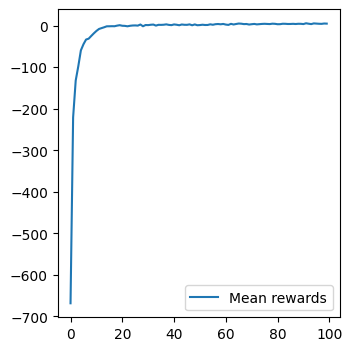

Episode: 10000, Reward: 6, Eps: 0.07394592752994535


In [18]:
# определяем память, в которой будет храниться Q(s,a)
Q = initialize_q_table(env.observation_space.n, env.action_space.n)
log = []
rewards_batch = []

# гиперпараметры алгоритма
alpha = 0.1
gamma = 0.8
epsilon = 0.2
epsilon_decay = 0.99
n_episodes = 10000

for i_episode in range(1, n_episodes + 1):
    s, _ = env.reset()

    r, episode_reward = 0, 0
    terminated = False

    while not terminated:
        # select action eps-greedy
        a = select_action_eps_greedy(Q, s, epsilon)
        
        # выполняем действие в среде
        next_s, r, terminated, truncated, _ = env.step(a)

        # Update Q-function
        update_Q(Q, s, a, r, next_s, alpha, gamma)

        s = next_s
        episode_reward += r

    rewards_batch.append(episode_reward)
    if i_episode % 100 == 0:
        show_progress(rewards_batch, log)
        rewards_batch = []
        print(
            f"Episode: {i_episode}, Reward: {episode_reward}"
            f", Eps: {epsilon}"
        )
        epsilon *= epsilon_decay

assert log[-1] >= -10

### Интерпретация результатов (1 балл):
Если все сделано правильно, то график должен выйти на плато около 0. Значение вознаграждение будет в диапазоне [-5, 10], за счет случайного выбора начальной позиции такси и пассажира. Попробуйте изменить гиперпараметры и сравните результаты.

При увеличении epsilon, средняя награда меньше (и стартовая тоже). При eps=0.2 изначальный средний reward = -600 (конечный средний reward=10), при eps=0.8 изначальный средний reward = -1500 (конечный средний reward = 6).

При увеличении alpha, алгоритм быстрее сходится, но дальше от идеальной границы. Т.е. разумно брать alpha 0.25-0.4

## SARSA

Теперь ради интереса попробуем то же самое, но используя метод SARSA.

Для начала, добавим функцию обновления Q-функции (1 балл):

In [21]:
def update_Q_SARSA(Q, s, a, r, next_s, alpha, gamma, epsilon):
    # выбери следующее действие eps-greedy
    next_a = select_action_eps_greedy(Q, next_s, epsilon)

    # посчитай TD ошибку
    td_error = r + gamma * Q[next_s, next_a] - Q[s, a]

    # обновление Q-функции
    Q[s, a] += alpha * td_error


Допишите код итерации SARSA-обучения (2 балла):

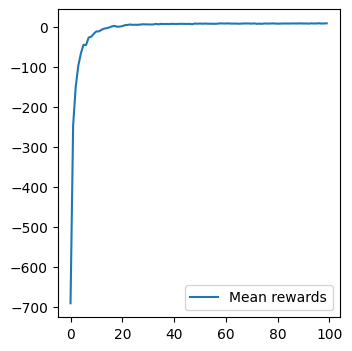

Episode: 10000, Reward: 12, Eps: 0.001246427204280841


In [22]:
# определяем память, в которой будет храниться Q(s,a)
Q = initialize_q_table(env.observation_space.n, env.action_space.n)
log = []
rewards_batch = []

# гиперпараметры алгоритма
alpha = 0.1
gamma = 0.9
epsilon = 0.2
epsilon_decay = 0.95
episodes_number = 10000

for episode in range(1, episodes_number + 1):
    s, _ = env.reset()

    r, episode_reward = 0, 0
    terminated = False

    while not terminated:
        # select action eps-greedy
        a = select_action_eps_greedy(Q, s, epsilon)

        # выполняем действие в среде
        next_s, r, terminated, truncated, info = env.step(a)

        # Update Q-function with SARSA
        update_Q_SARSA(Q, s, a, r, next_s, alpha, gamma, epsilon)

        s = next_s
        episode_reward += r

    rewards_batch.append(episode_reward)
    if episode % 100 == 0:

        show_progress(rewards_batch, log)
        rewards_batch = []
        print(f"Episode: {episode}, Reward: {episode_reward}, Eps: {epsilon}")
        epsilon *= epsilon_decay

assert log[-1] >= -10

Сравнивая SARSA и Q-learning, что можно сказать об их кривых обучения? (быстрее-медленнее, обучение стабильнее или нет и тп) (1 балл)

Q-learning сходится быстрее, имеет меньший exploration фактор, тем самым более подходит для не стохастических сред.

SARSA подходит, если важно учитывать текущую стратегию и избегать опасных действий. Т.е. он больше учитывает нашу текущую стратегию, потому что обновляет значение не максимумом, а Q(S_{t+1}, A_{t+1})
